In [4]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity as ssim


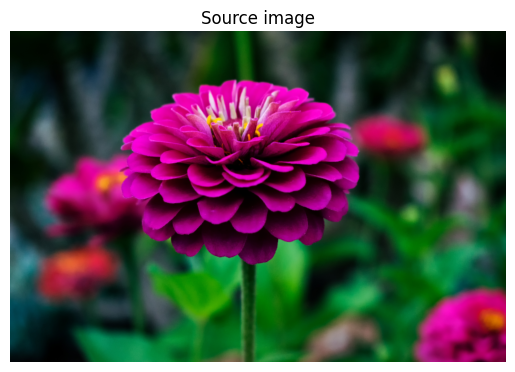

In [5]:
# Загрузка исходного изображние 

img = cv2.cvtColor(cv2.imread('img.jpg'), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title('Source image')
plt.axis('off')
plt.show()

In [6]:
# 1. Зашумить изображение при помощи шума гаусса, постоянного шума.


def apply_gaussian_noise(img, sigma, mean = 0):

    # Генерация шума
    gaussian_noise = np.random.normal(mean, sigma, img.shape)

    # Добавляем шум и обрезаем диапазон [0,255]
    noisy_img = img + gaussian_noise
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)

    return noisy_img


def apply_salt_pepper_noise(img, salt_prob=0.05, pepper_prob=0.05):
    
    noisy_img = img.copy()
    
    salt_mask = np.random.random(img.shape[:2]) < salt_prob
    pepper_mask = np.random.random(img.shape[:2]) < pepper_prob
    
    noisy_img[salt_mask] = 255
    noisy_img[pepper_mask] = 0
    
    return noisy_img

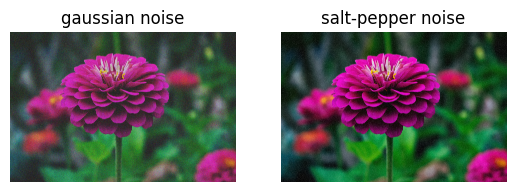

In [7]:

gn_img = apply_gaussian_noise(img, 100)
spn_img = apply_salt_pepper_noise(img)

# Первое изображение
plt.subplot(1, 2, 1)   # 1 строка, 2 столбца, 1-й график
plt.imshow(gn_img)
plt.axis('off')
plt.title("gaussian noise")

# Второе изображение
plt.subplot(1, 2, 2)   # 1 строка, 2 столбца, 2-й график
plt.imshow(spn_img)
plt.axis('off')
plt.title("salt-pepper noise")

plt.show()



In [8]:
noisy_image = gn_img

# Медианный фильтр с различными размерами окна (ядра)
def test_median_filters(noisy_image):
    return {
        'median_3': cv2.medianBlur(noisy_image, 3),
        'median_5' : cv2.medianBlur(noisy_image, 5),
        'median_7' : cv2.medianBlur(noisy_image, 7)
    }

# Гауссов фильтр с различными размерами окна (ядра) 
# и стандартного отклонения
def test_gaussian_filters(noisy_image):
    return {
        'gauss_3' : cv2.GaussianBlur(noisy_image, (3, 3), 0),
        'gauss_5' : cv2.GaussianBlur(noisy_image, (5, 5), 1),
        'gauss_7' : cv2.GaussianBlur(noisy_image, (7, 7), 2)
    }
    
# Билатеральный фильтр с различными парметрами 
# диаметра области фильтрации, фильрации по цвету 
# и фильтрации по пространству 
def test_bilateral_filters(noisy_image):
    return {
        'bilateral_d9_s50' : cv2.bilateralFilter(noisy_image, 5, 50, 50),
        'bilateral_d9_s75' : cv2.bilateralFilter(noisy_image, 9, 75, 75),
        'bilateral_d15_s100' : cv2.bilateralFilter(noisy_image, 15, 100, 100)
    }

# Фильтр нелокальных средних
def test_nlm_filters(noisy_image):
    return {
        'nlm_h10' : cv2.fastNlMeansDenoisingColored(noisy_image, None, 10, 10, 7, 21),
        'nlm_h15' : cv2.fastNlMeansDenoisingColored(noisy_image, None, 15, 15, 7, 21),
        'nlm_h20' : cv2.fastNlMeansDenoisingColored(noisy_image, None, 20, 20, 7, 21)
    }


In [9]:
def calculate_psnr(original, filtered):
    mse = np.mean((original.astype(float) - filtered.astype(float)) ** 2)
    return 20 * np.log10(255.0 / np.sqrt(mse)) if mse != 0 else float('inf')

def calculate_ssim(original, filtered):
    if len(original.shape) == 3:
        original = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
        filtered = cv2.cvtColor(filtered, cv2.COLOR_RGB2GRAY)
    return ssim(original, filtered)

In [27]:
def analyze_img(image, noisy_image):
    # print(f"Начальный PSNR: {calculate_psnr(image, noisy_image):.2f} dB")

    filtering_results = {}
    filtering_results.update(test_median_filters(noisy_image))
    filtering_results.update(test_gaussian_filters(noisy_image))
    filtering_results.update(test_bilateral_filters(noisy_image))
    filtering_results.update(test_nlm_filters(noisy_image))

    results = []
    for name, filtered in filtering_results.items():
        psnr = calculate_psnr(image, filtered)
        ssim = calculate_ssim(image, filtered)
        results.append((name, psnr, ssim, filtered))

    results.sort(key=lambda x: x[1], reverse=True)

    return results

def show_results(results, source, noisy, noise_type):

    plt.figure(figsize=(20, 10))
    
    for i, (name, psnr, ssim, _) in enumerate(results[:5], 1):
        print(f"{i}. {name}: PSNR = {psnr:.2f} dB, SSIM = {ssim:.4f}")
    
    for i, (name, psnr, ssim, filtered) in enumerate(results[:5], 1):
        plt.subplot(1, 5, i)
        plt.imshow(filtered)
        plt.title(f'{name}')
        plt.axis('off')
    
    plt.show()

        


1. median_7: PSNR = 23.71 dB, SSIM = 0.4598
2. median_5: PSNR = 21.11 dB, SSIM = 0.2965
3. gauss_7: PSNR = 19.06 dB, SSIM = 0.5081
4. gauss_5: PSNR = 17.81 dB, SSIM = 0.2669
5. median_3: PSNR = 17.27 dB, SSIM = 0.1356


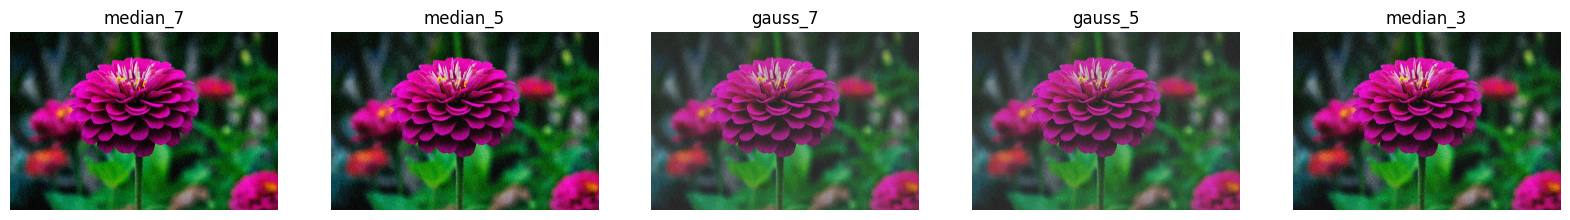

In [28]:

show_results(analyze_img(img, gn_img), img, gn_img, 'шум гаусса');

1. median_3: PSNR = 38.24 dB, SSIM = 0.9061
2. median_5: PSNR = 37.15 dB, SSIM = 0.8553
3. median_7: PSNR = 37.10 dB, SSIM = 0.8539
4. gauss_7: PSNR = 26.46 dB, SSIM = 0.5840
5. gauss_5: PSNR = 23.80 dB, SSIM = 0.3449


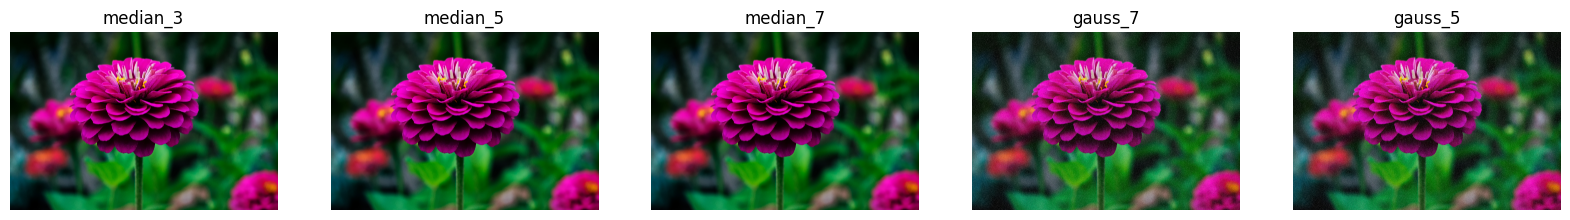

In [29]:
show_results(analyze_img(img, spn_img), img, spn_img, 'salp-pepper');